# init

In [1]:
from tensorflow import keras 
import pandas as pd 
import numpy as np 
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt 
import seaborn as sns 
import os 
from datetime import datetime

# Data reading

In [3]:
df = pd.read_csv("MicrosoftStock.csv")

In [4]:
df.head()

,index,date,open,high,low,close,volume,Name
0,390198,2013-02-08,27.35,27.71,27.31,27.55,33318306,MSFT
1,390199,2013-02-11,27.65,27.92,27.50,27.86,32247549,MSFT
2,390200,2013-02-12,27.88,28.00,27.75,27.88,35990829,MSFT
3,390201,2013-02-13,27.93,28.11,27.88,28.03,41715530,MSFT
4,390202,2013-02-14,27.92,28.06,27.87,28.04,32663174,MSFT


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   1259 non-null   int64  
 1   date    1259 non-null   object 
 2   open    1259 non-null   float64
 3   high    1259 non-null   float64
 4   low     1259 non-null   float64
 5   close   1259 non-null   float64
 6   volume  1259 non-null   int64  
 7   Name    1259 non-null   object 
dtypes: float64(4), int64(2), object(2)
memory usage: 78.8+ KB


In [7]:
df.describe()

,index,open,high,low,close,volume
count,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1.259000e+03
mean,390827.000000,51.026394,51.436007,50.630397,51.063081,3.386946e+07
std,363.586303,14.859387,14.930144,14.774630,14.852117,1.958979e+07
min,390198.000000,27.350000,27.600000,27.230000,27.370000,7.425603e+06
25%,390512.500000,40.305000,40.637500,39.870000,40.310000,2.254879e+07
50%,390827.000000,47.440000,47.810000,47.005000,47.520000,2.938758e+07
75%,391141.500000,59.955000,60.435000,59.275000,59.730000,3.842024e+07
max,391456.000000,95.140000,96.070000,93.720000,95.010000,2.483542e+08


## Some visuals

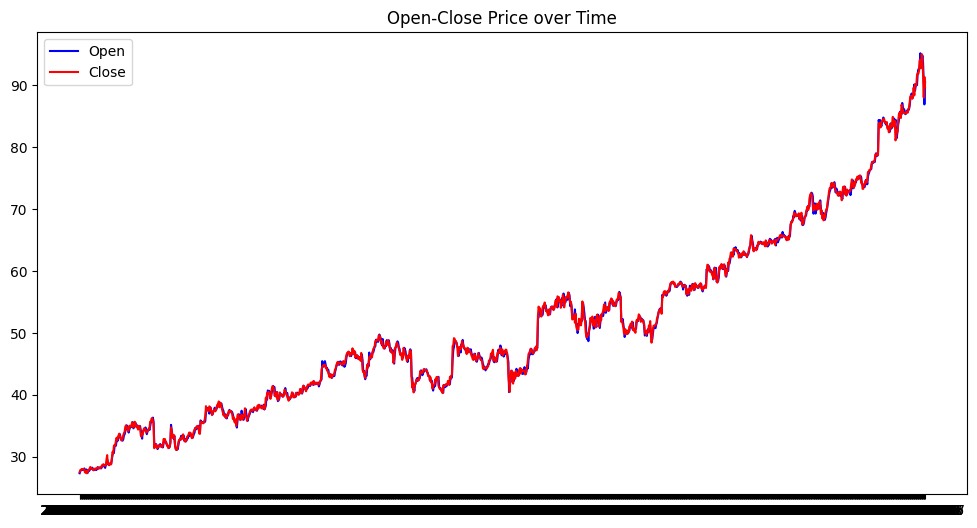

In [13]:
plt.figure(figsize=(12,6))
plt.plot(df['date'], df['open'], label="Open",color="blue")
plt.plot(df['date'], df['close'], label="Close",color="red")
plt.title("Open-Close Price over Time")
plt.legend()
plt.show()

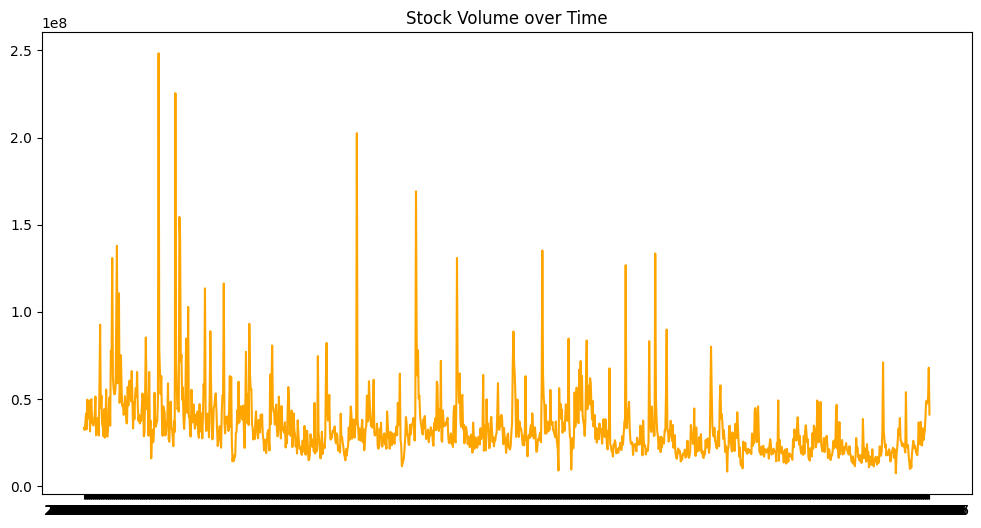

In [12]:
plt.figure(figsize=(12,6))
plt.plot(df['date'],df['volume'],label="Volume",color="orange")
plt.title("Stock Volume over Time")
plt.show()

In [14]:
numeric_data = df.select_dtypes(include=["int64","float64"])

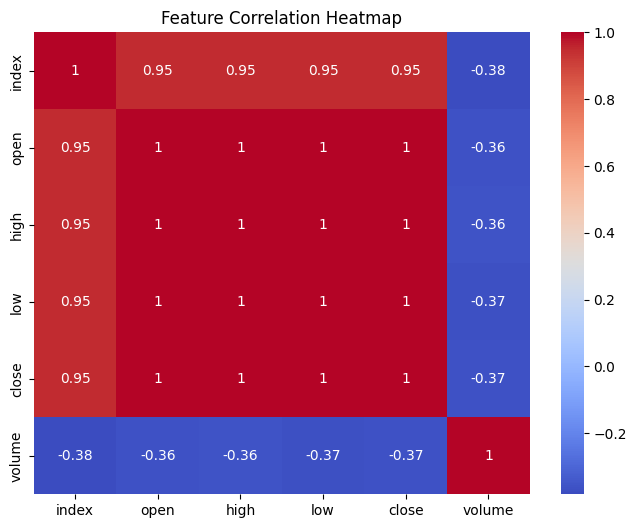

In [15]:
plt.figure(figsize=(8,6))
sns.heatmap(numeric_data.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

# Data cleaning

In [18]:
df['date'] = pd.to_datetime(df['date'])

In [19]:
prediction = df.loc[
    (df['date'] > datetime(2013,1,1)) &
    (df['date'] < datetime(2018,1,1))
]

Text(0.5, 1.0, 'Price over time')

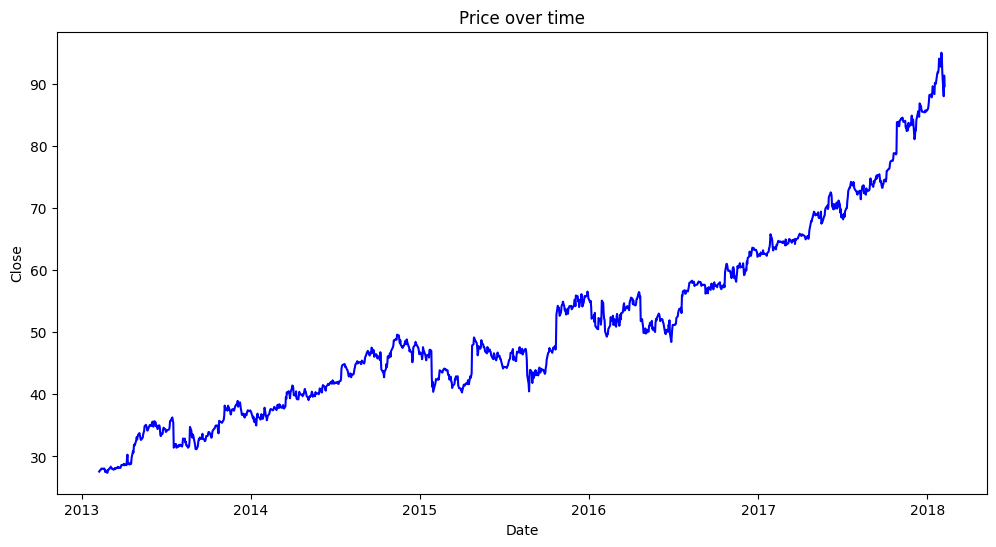

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(df['date'], df['close'], color="blue")
plt.xlabel("Date")
plt.ylabel("Close")
plt.title("Price over time")

# Building the LSTM model

In [32]:
stock_close = df.filter(["close"])
dataset = stock_close.values #convert to numpy array
training_data_len = int(np.ceil(len(dataset) * 0.95))

In [33]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(dataset)

In [34]:
training_data = scaled_data[:training_data_len] #95% of all out data

In [35]:
X_train, y_train = [], []

In [36]:
# Create a sliding window for our stock (60 days)
for i in range(60, len(training_data)):
    X_train.append(training_data[i-60:i, 0])
    y_train.append(training_data[i, 0])

In [37]:
X_train, y_train = np.array(X_train), np.array(y_train)

In [38]:
X_train

array([[-1.58377587, -1.56289513, -1.56154799, ..., -1.20590184,
        -1.18367395, -1.16616107],
       [-1.56289513, -1.56154799, -1.5514444 , ..., -1.18367395,
        -1.16616107, -1.19579825],
       [-1.56154799, -1.5514444 , -1.55077083, ..., -1.16616107,
        -1.19579825, -1.21735256],
       ...,
       [ 1.37051203,  1.44393141,  1.51735079, ...,  2.16330658,
         2.16330658,  2.22190736],
       [ 1.44393141,  1.51735079,  1.49242861, ...,  2.16330658,
         2.22190736,  2.22796951],
       [ 1.51735079,  1.49242861,  1.52139222, ...,  2.22190736,
         2.22796951,  2.2501974 ]])

In [39]:
X_train.shape

(1137, 60)

In [40]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [41]:
X_train.shape

(1137, 60, 1)

In [42]:
# Build the Model
model = keras.models.Sequential()
model.add(keras.layers.LSTM(64, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(keras.layers.LSTM(64, return_sequences=False))
model.add(keras.layers.Dense(128, activation="relu"))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1))

In [43]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 64)            16896     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 58,369
Trainable params: 58,369
Non-trainable params: 0
_________________________________________________________________


In [44]:
model.compile(optimizer="adam", loss="mae", metrics=[keras.metrics.RootMeanSquaredError()])

In [45]:
training = model.fit(X_train, y_train, epochs=20, batch_size=32)

Epoch 1/20
36/36 [==============================] - 10s 17ms/step - loss: 0.2542 - root_mean_squared_error: 0.3720
Epoch 2/20
36/36 [==============================] - 1s 16ms/step - loss: 0.1355 - root_mean_squared_error: 0.1848
Epoch 3/20
36/36 [==============================] - 1s 15ms/step - loss: 0.1252 - root_mean_squared_error: 0.1706
Epoch 4/20
36/36 [==============================] - 1s 16ms/step - loss: 0.1148 - root_mean_squared_error: 0.1574
Epoch 5/20
36/36 [==============================] - 1s 16ms/step - loss: 0.1131 - root_mean_squared_error: 0.1529
Epoch 6/20
36/36 [==============================] - 1s 15ms/step - loss: 0.1090 - root_mean_squared_error: 0.1471
Epoch 7/20
36/36 [==============================] - 1s 15ms/step - loss: 0.1065 - root_mean_squared_error: 0.1433
Epoch 8/20
36/36 [==============================] - 1s 16ms/step - loss: 0.1109 - root_mean_squared_error: 0.1501
Epoch 9/20
36/36 [==============================] - 1s 16ms/step - loss: 0.1152 - root_

# Testing the model

In [46]:
test_data = scaled_data[training_data_len - 60:]
X_test, y_test = [], dataset[training_data_len:]

In [47]:
for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, 0])

In [48]:
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1 ))

In [49]:
# Make a Prediction
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

2/2 [==============================] - 1s 15ms/step


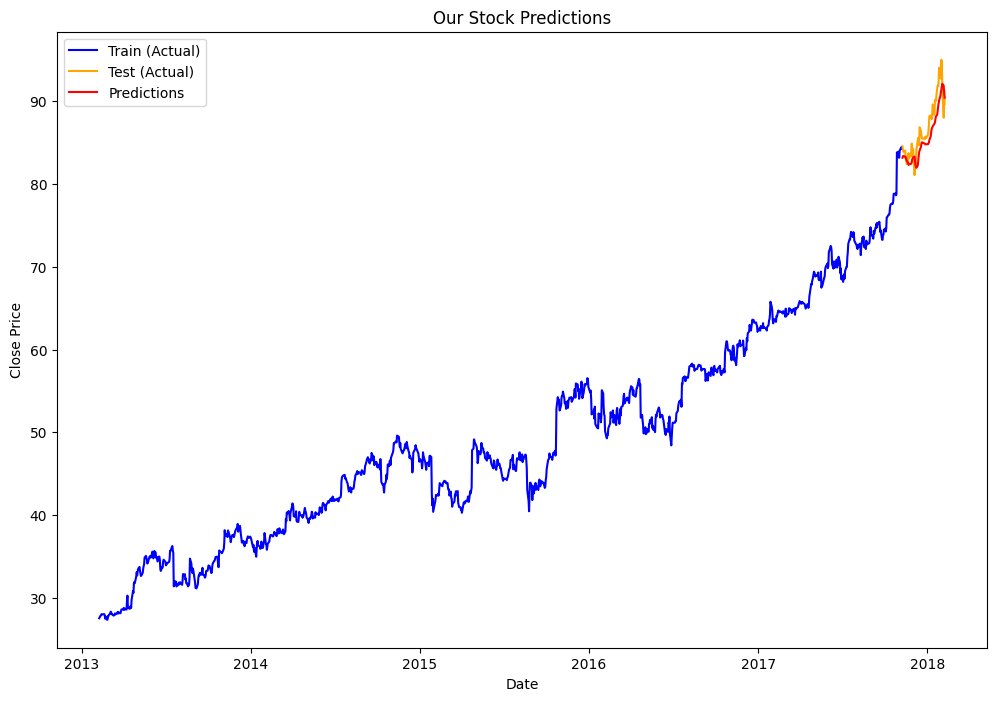

In [51]:
# Plotting data
train = df[:training_data_len]
test =  df[training_data_len:]

test = test.copy()

test['Predictions'] = predictions

plt.figure(figsize=(12,8))
plt.plot(train['date'], train['close'], label="Train (Actual)", color='blue')
plt.plot(test['date'], test['close'], label="Test (Actual)", color='orange')
plt.plot(test['date'], test['Predictions'], label="Predictions", color='red')
plt.title("Our Stock Predictions")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()